# GLM Visual Optimization - Automatic Best Grouping Selection

Finding optimal variable groupings through visual analysis and statistical tests.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import glm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11
%matplotlib inline

## 1. Data Loading & Preparation

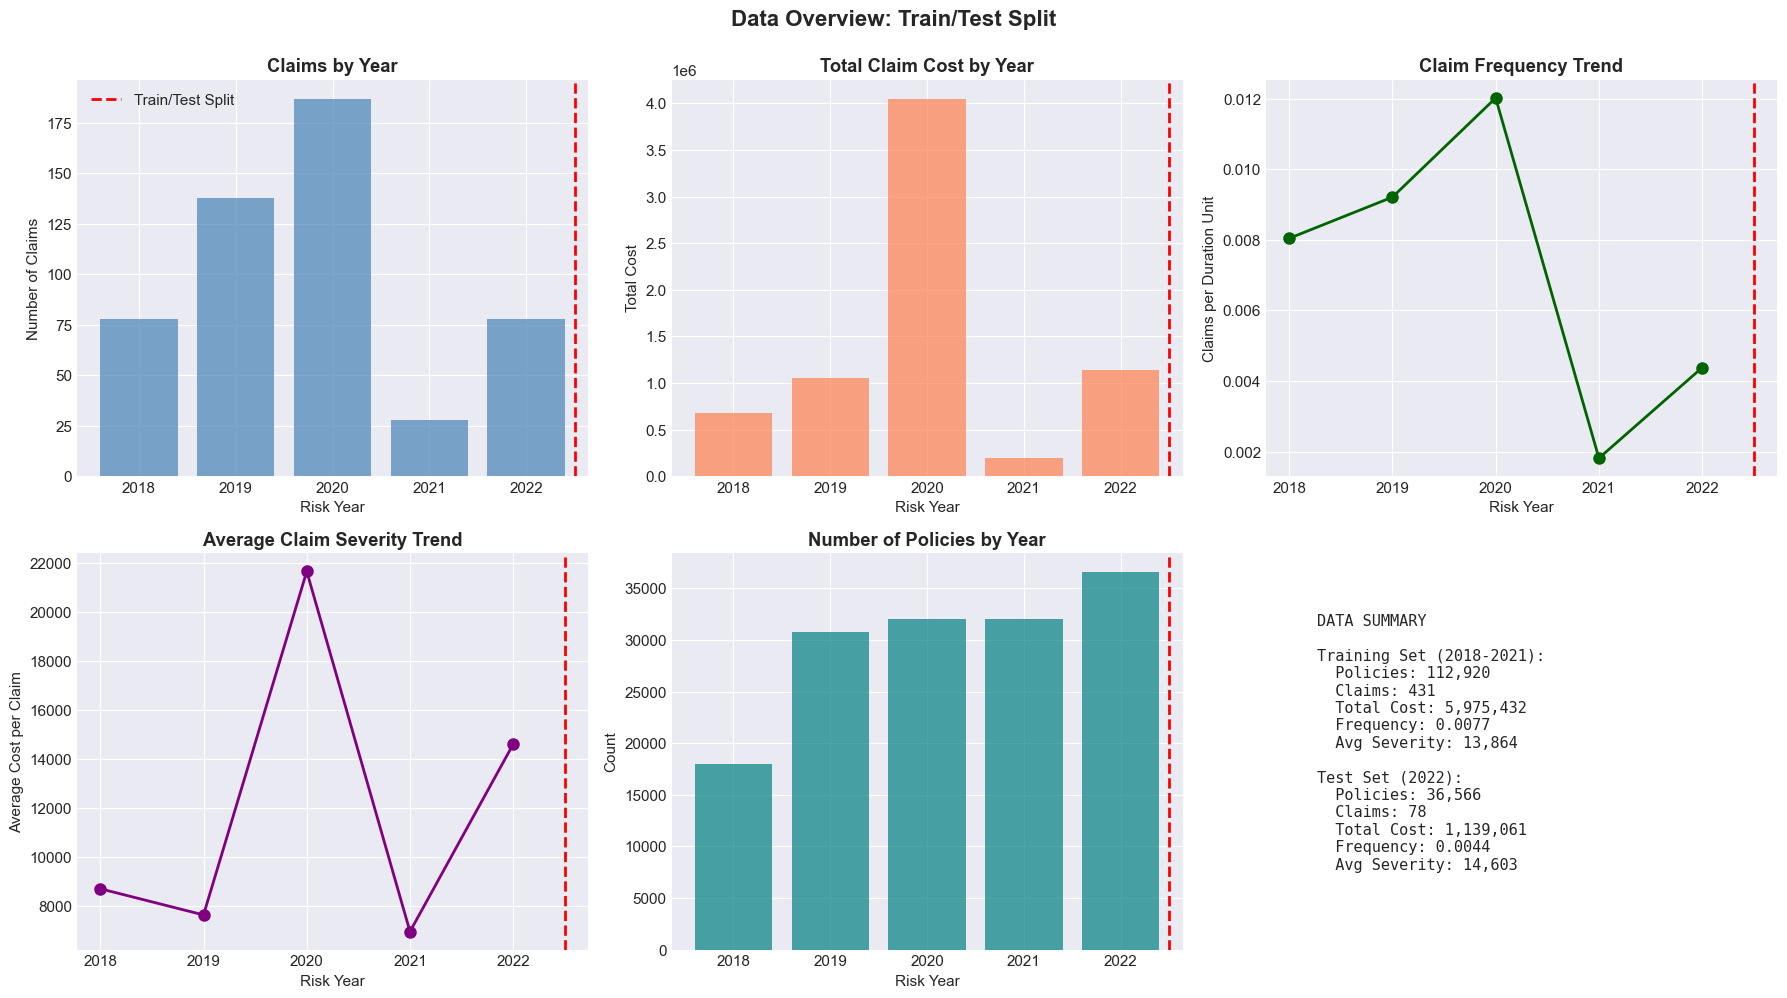

In [15]:
# Load and split data
df_full = pd.read_csv('GLM_KTH_Data_Train.csv')
df_train = df_full[df_full['RiskYear'] < 2022].copy()
df_test = df_full[df_full['RiskYear'] == 2022].copy()

# Data summary visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Claims by year
claims_by_year = df_full.groupby('RiskYear')['NumberOfClaims'].sum()
axes[0, 0].bar(claims_by_year.index, claims_by_year.values, color='steelblue', alpha=0.7)
axes[0, 0].axvline(2022.5, color='red', linestyle='--', linewidth=2, label='Train/Test Split')
axes[0, 0].set_title('Claims by Year', fontweight='bold')
axes[0, 0].set_xlabel('Risk Year')
axes[0, 0].set_ylabel('Number of Claims')
axes[0, 0].legend()

# Cost by year
cost_by_year = df_full.groupby('RiskYear')['ClaimCost'].sum()
axes[0, 1].bar(cost_by_year.index, cost_by_year.values, color='coral', alpha=0.7)
axes[0, 1].axvline(2022.5, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Total Claim Cost by Year', fontweight='bold')
axes[0, 1].set_xlabel('Risk Year')
axes[0, 1].set_ylabel('Total Cost')

# Frequency trend
freq_by_year = df_full.groupby('RiskYear').apply(lambda x: x['NumberOfClaims'].sum() / x['Duration'].sum())
axes[0, 2].plot(freq_by_year.index, freq_by_year.values, 'o-', linewidth=2, markersize=8, color='darkgreen')
axes[0, 2].axvline(2022.5, color='red', linestyle='--', linewidth=2)
axes[0, 2].set_title('Claim Frequency Trend', fontweight='bold')
axes[0, 2].set_xlabel('Risk Year')
axes[0, 2].set_ylabel('Claims per Duration Unit')

# Severity trend
sev_by_year = df_full[df_full['NumberOfClaims'] > 0].groupby('RiskYear').apply(
    lambda x: x['ClaimCost'].sum() / x['NumberOfClaims'].sum())
axes[1, 0].plot(sev_by_year.index, sev_by_year.values, 'o-', linewidth=2, markersize=8, color='purple')
axes[1, 0].axvline(2022.5, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Average Claim Severity Trend', fontweight='bold')
axes[1, 0].set_xlabel('Risk Year')
axes[1, 0].set_ylabel('Average Cost per Claim')

# Policies count
policies_by_year = df_full.groupby('RiskYear').size()
axes[1, 1].bar(policies_by_year.index, policies_by_year.values, color='teal', alpha=0.7)
axes[1, 1].axvline(2022.5, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Number of Policies by Year', fontweight='bold')
axes[1, 1].set_xlabel('Risk Year')
axes[1, 1].set_ylabel('Count')

# Summary stats
axes[1, 2].axis('off')
summary_text = f"""DATA SUMMARY

Training Set (2018-2021):
  Policies: {len(df_train):,}
  Claims: {df_train['NumberOfClaims'].sum():,}
  Total Cost: {df_train['ClaimCost'].sum():,.0f}
  Frequency: {df_train['NumberOfClaims'].sum() / df_train['Duration'].sum():.4f}
  Avg Severity: {df_train['ClaimCost'].sum() / df_train['NumberOfClaims'].sum():,.0f}

Test Set (2022):
  Policies: {len(df_test):,}
  Claims: {df_test['NumberOfClaims'].sum():,}
  Total Cost: {df_test['ClaimCost'].sum():,.0f}
  Frequency: {df_test['NumberOfClaims'].sum() / df_test['Duration'].sum():.4f}
  Avg Severity: {df_test['ClaimCost'].sum() / df_test['NumberOfClaims'].sum():,.0f}
"""
axes[1, 2].text(0.1, 0.5, summary_text, fontsize=11, family='monospace', 
                verticalalignment='center')

plt.suptitle('Data Overview: Train/Test Split', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 2. Grouping Strategies Definition

In [16]:
COLUMN_MAPPING = {
    'NoPGroup': 'NumberOfPersons',
    'ActivityGroup': 'ActivityCode',
    'FinancialRatingGroup': 'FinancialRating',
    'TravellingAreaGroup': 'TravellingArea'
}

def create_grouping_strategies():
    strategies = {}
    
    # NumberOfPersons - 4 strategies from simple to detailed
    strategies['NoPGroup'] = {
        'v1_simple': lambda x: pd.cut(x, bins=[0, 5, 30, np.inf], 
                                       labels=['1-5', '6-30', '>30']),
        'v2_medium': lambda x: pd.cut(x, bins=[0, 2, 5, 15, 50, 100, np.inf], 
                                       labels=['1-2', '3-5', '6-15', '16-50', '51-100', '>100']),
        'v3_detailed': lambda x: pd.cut(x, bins=[0, 1, 2, 5, 10, 20, 50, 100, np.inf], 
                                         labels=['1', '2', '3-5', '6-10', '11-20', '21-50', '51-100', '>100']),
        'v4_fine': lambda x: pd.cut(x, bins=[0, 1, 3, 7, 12, 25, 50, 100, 200, np.inf],
                                    labels=['1', '2-3', '4-7', '8-12', '13-25', '26-50', '51-100', '101-200', '>200'])
    }
    
    # ActivityCode
    strategies['ActivityGroup'] = {
        'v1_simple': lambda x: x.apply(lambda c: 
                                        'Industry' if c in ['C', 'F', 'B', 'D', 'E'] else
                                        'Services' if c in ['G', 'K', 'M', 'L', 'N', 'J'] else
                                        'Public' if c in ['O', 'P', 'Q'] else
                                        'Other'),
        'v2_medium': lambda x: x.apply(lambda c: 
                                        'Manufacturing' if c in ['C', 'D', 'E'] else
                                        'Construction' if c in ['F', 'B'] else
                                        'Finance/Consulting' if c in ['K', 'M', 'J'] else
                                        'Trade' if c == 'G' else
                                        'Public/Care' if c in ['O', 'P', 'Q'] else
                                        'Other'),
        'v3_detailed': lambda x: x.apply(lambda c:
                                         'Manufacturing' if c == 'C' else
                                         'Construction' if c == 'F' else
                                         'Trade' if c == 'G' else
                                         'Transport' if c == 'H' else
                                         'Consulting' if c == 'J' else
                                         'Finance' if c == 'K' else
                                         'Professional' if c == 'M' else
                                         'Public' if c == 'O' else
                                         'Care' if c == 'Q' else
                                         'Other'),
        'v4_minimal': lambda x: x.apply(lambda c:
                                        'High_Risk' if c in ['F', 'H', 'I', 'B'] else
                                        'Low_Risk')
    }
    
    # FinancialRating
    strategies['FinancialRatingGroup'] = {
        'v1_simple': lambda x: x.apply(lambda r: 
                                        'High' if r in ['AAA', 'AA', 'A'] else
                                        'Medium' if r in ['B', 'BB', 'BBB'] else
                                        'Low'),
        'v2_medium': lambda x: x.apply(lambda r: 
                                        'AAA_AA' if r in ['AAA', 'AA'] else
                                        'A' if r == 'A' else
                                        'B_group' if r in ['B', 'BB', 'BBB'] else
                                        'Low'),
        'v3_detailed': lambda x: x.apply(lambda r:
                                         'AAA' if r == 'AAA' else
                                         'AA' if r == 'AA' else
                                         'A' if r == 'A' else
                                         'B' if r in ['B', 'BB', 'BBB'] else
                                         'C' if r == 'C' else
                                         'Low'),
        'v4_binary': lambda x: x.apply(lambda r:
                                       'Good' if r in ['AAA', 'AA', 'A'] else
                                       'Other')
    }
    
    # TravellingArea
    strategies['TravellingAreaGroup'] = {
        'v1_simple': lambda x: x.apply(lambda a: 
                                        'Sweden' if a == 'Sweden' else 'International'),
        'v2_medium': lambda x: x.apply(lambda a: 
                                        'Sweden' if a == 'Sweden' else
                                        'Nordic' if 'Scandinavia' in str(a) or 'Nordic' in str(a) else
                                        'Europe' if 'Europe' in str(a) else
                                        'World'),
        'v3_detailed': lambda x: x
    }
    
    return strategies

grouping_strategies = create_grouping_strategies()

## 3. Univariate Risk Analysis

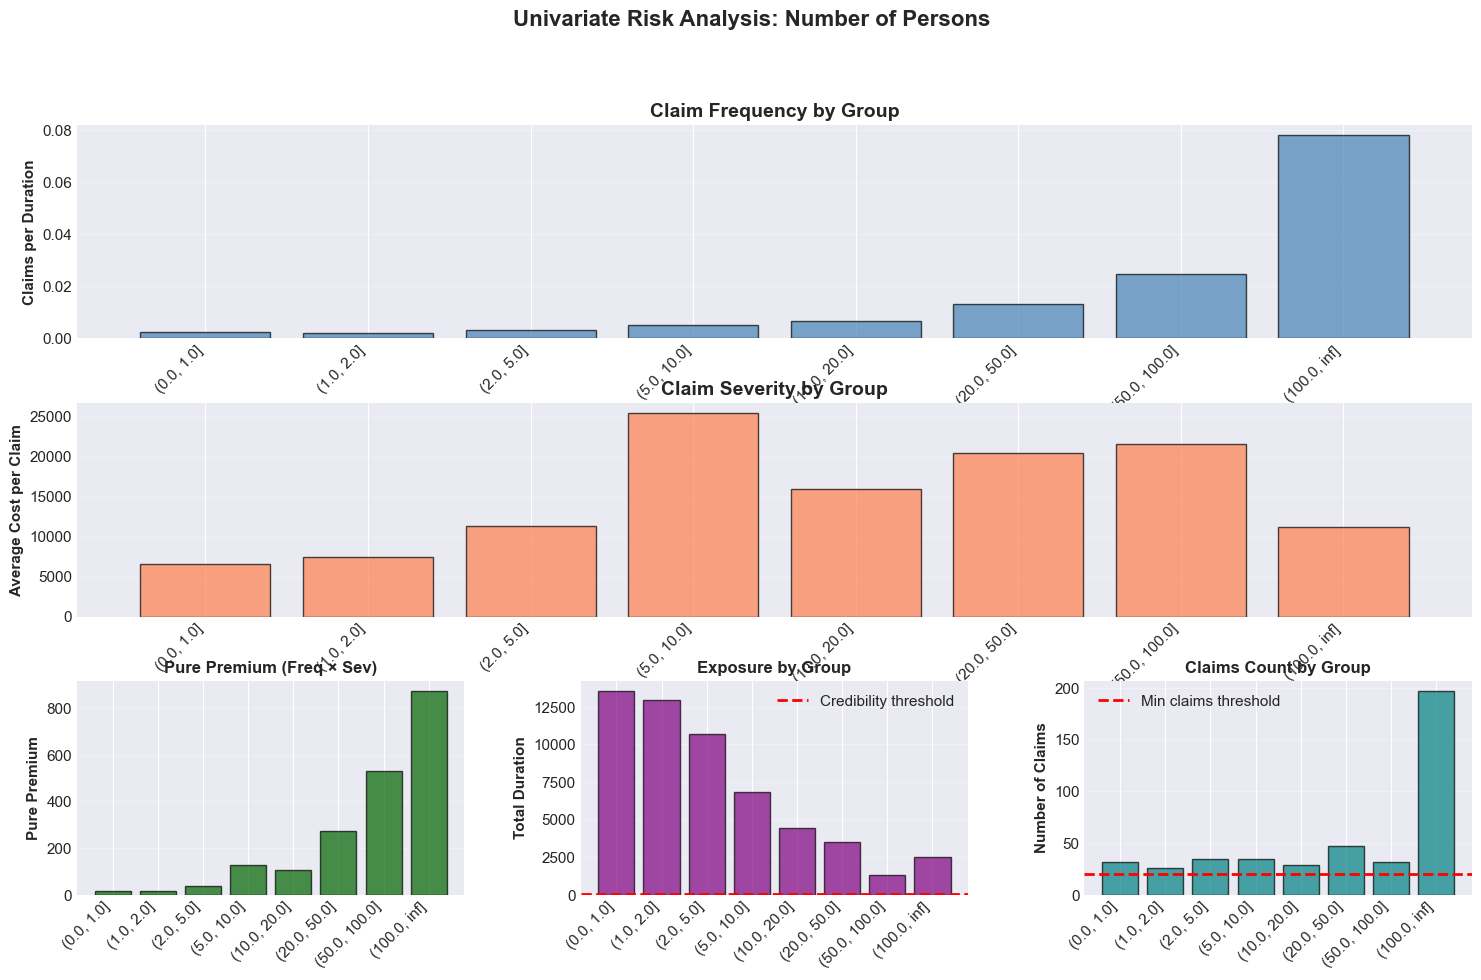

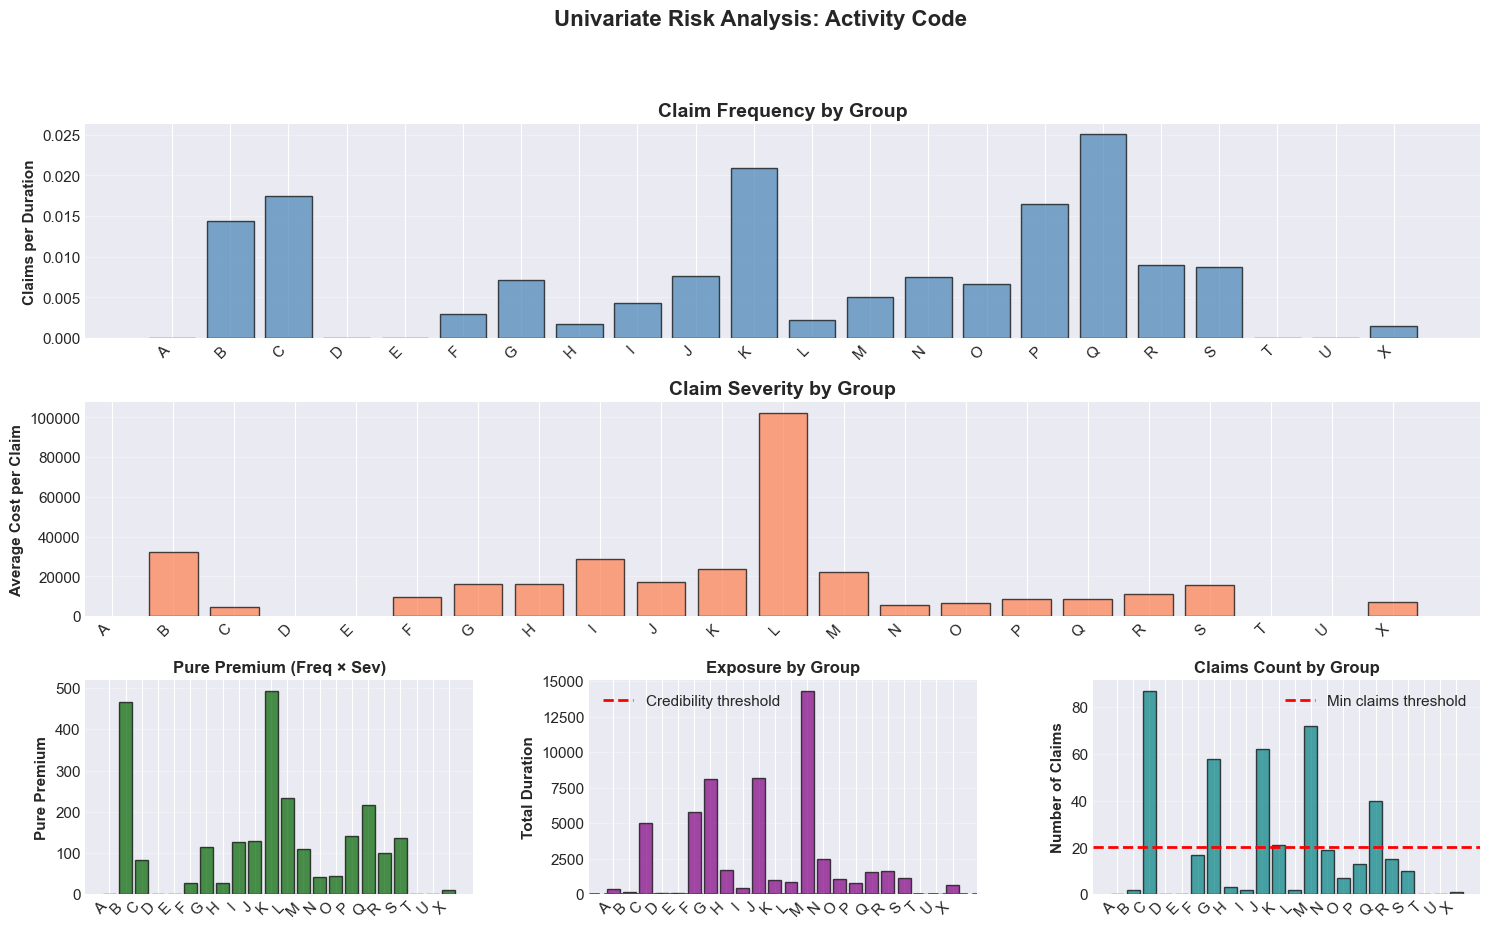

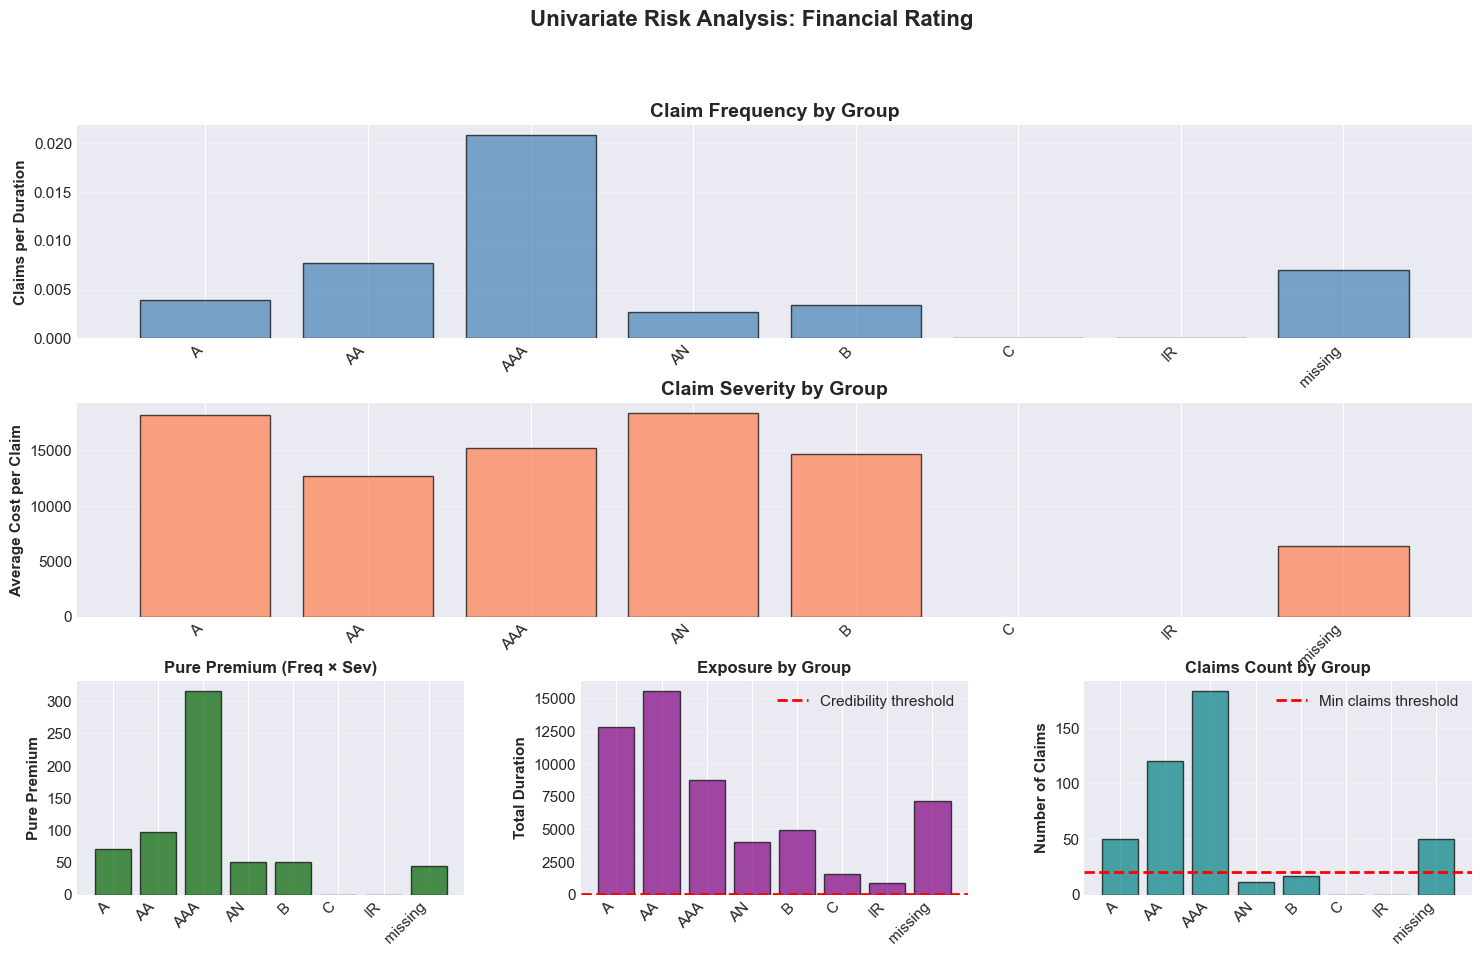

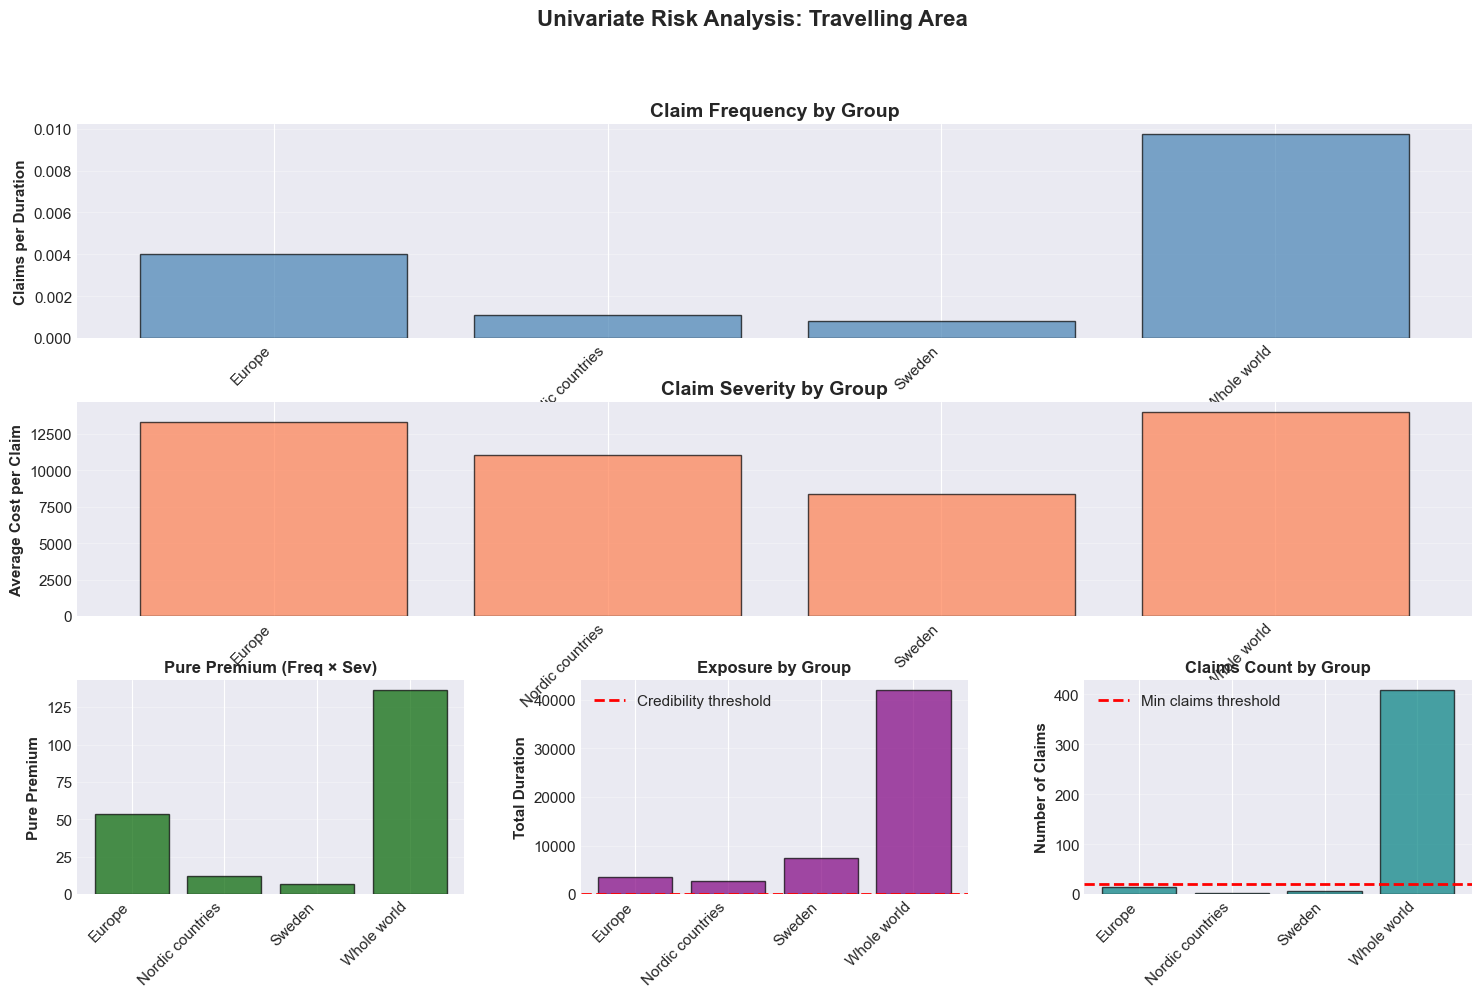

In [17]:
def plot_univariate_risk(df, variable, original_col, title):
    """Visual analysis of risk by variable"""
    
    # Binning for continuous variables
    if df[original_col].dtype in ['int64', 'float64']:
        df_plot = df.copy()
        if original_col == 'NumberOfPersons':
            bins = [0, 1, 2, 5, 10, 20, 50, 100, np.inf]
        elif original_col == 'CompanyAge':
            bins = [0, 3, 5, 10, 15, 20, np.inf]
        else:
            bins = 10
        df_plot['bin'] = pd.cut(df[original_col], bins=bins)
        group_col = 'bin'
    else:
        df_plot = df
        group_col = original_col
    
    # Aggregate
    agg = df_plot.groupby(group_col, observed=True).agg({
        'Duration': 'sum',
        'NumberOfClaims': 'sum',
        'ClaimCost': 'sum'
    })
    
    agg['Frequency'] = agg['NumberOfClaims'] / agg['Duration']
    agg['AvgSeverity'] = agg['ClaimCost'] / agg['NumberOfClaims'].replace(0, np.nan)
    agg['PurePremium'] = agg['ClaimCost'] / agg['Duration']
    
    # Plot
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Frequency
    ax1 = fig.add_subplot(gs[0, :])
    x = range(len(agg))
    ax1.bar(x, agg['Frequency'], color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_xticks(x)
    ax1.set_xticklabels(agg.index, rotation=45, ha='right')
    ax1.set_ylabel('Claims per Duration', fontweight='bold')
    ax1.set_title('Claim Frequency by Group', fontweight='bold', fontsize=14)
    ax1.grid(axis='y', alpha=0.3)
    
    # Severity
    ax2 = fig.add_subplot(gs[1, :])
    ax2.bar(x, agg['AvgSeverity'], color='coral', alpha=0.7, edgecolor='black')
    ax2.set_xticks(x)
    ax2.set_xticklabels(agg.index, rotation=45, ha='right')
    ax2.set_ylabel('Average Cost per Claim', fontweight='bold')
    ax2.set_title('Claim Severity by Group', fontweight='bold', fontsize=14)
    ax2.grid(axis='y', alpha=0.3)
    
    # Pure Premium
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.bar(x, agg['PurePremium'], color='darkgreen', alpha=0.7, edgecolor='black')
    ax3.set_xticks(x)
    ax3.set_xticklabels(agg.index, rotation=45, ha='right')
    ax3.set_ylabel('Pure Premium', fontweight='bold')
    ax3.set_title('Pure Premium (Freq × Sev)', fontweight='bold', fontsize=12)
    ax3.grid(axis='y', alpha=0.3)
    
    # Exposure
    ax4 = fig.add_subplot(gs[2, 1])
    ax4.bar(x, agg['Duration'], color='purple', alpha=0.7, edgecolor='black')
    ax4.axhline(50, color='red', linestyle='--', linewidth=2, label='Credibility threshold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(agg.index, rotation=45, ha='right')
    ax4.set_ylabel('Total Duration', fontweight='bold')
    ax4.set_title('Exposure by Group', fontweight='bold', fontsize=12)
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    # Claims count
    ax5 = fig.add_subplot(gs[2, 2])
    ax5.bar(x, agg['NumberOfClaims'], color='teal', alpha=0.7, edgecolor='black')
    ax5.axhline(20, color='red', linestyle='--', linewidth=2, label='Min claims threshold')
    ax5.set_xticks(x)
    ax5.set_xticklabels(agg.index, rotation=45, ha='right')
    ax5.set_ylabel('Number of Claims', fontweight='bold')
    ax5.set_title('Claims Count by Group', fontweight='bold', fontsize=12)
    ax5.legend()
    ax5.grid(axis='y', alpha=0.3)
    
    fig.suptitle(f'Univariate Risk Analysis: {title}', fontsize=16, fontweight='bold', y=0.995)
    plt.show()

# Analyze key variables
plot_univariate_risk(df_train, 'NumberOfPersons', 'NumberOfPersons', 'Number of Persons')
plot_univariate_risk(df_train, 'ActivityCode', 'ActivityCode', 'Activity Code')
plot_univariate_risk(df_train, 'FinancialRating', 'FinancialRating', 'Financial Rating')
plot_univariate_risk(df_train, 'TravellingArea', 'TravellingArea', 'Travelling Area')

## 4. Model Building Functions

In [18]:
def apply_grouping_config(df, config):
    df_copy = df.copy()
    for var, strategy_name in config.items():
        if strategy_name is None:
            continue
        strategy_func = grouping_strategies[var][strategy_name]
        source_col = COLUMN_MAPPING[var]
        df_copy[var] = strategy_func(df[source_col])
    return df_copy

def fit_glm_model(df, variables, model_type='frequency'):
    df_agg = (df[variables + ['Duration', 'NumberOfClaims', 'ClaimCost']]
              .groupby(variables, observed=True)
              .agg('sum')
              .reset_index())
    
    df_agg['AvgClaimCost'] = df_agg['ClaimCost'] / df_agg['NumberOfClaims']
    
    refs = {}
    for var in variables:
        refs[var] = df.groupby(var, observed=True)['Duration'].sum().idxmax()
    
    formula_parts = [f'C({var}, Treatment(reference="{refs[var]}"))' for var in variables]
    df_agg_filtered = df_agg[df_agg['Duration'] > 0.001].copy()
    
    try:
        if model_type == 'frequency':
            formula = 'NumberOfClaims ~ ' + ' + '.join(formula_parts)
            model = glm(formula=formula, data=df_agg_filtered,
                       family=sm.families.Poisson(),
                       exposure=df_agg_filtered['Duration']).fit()
        else:
            df_agg_filtered = df_agg_filtered[df_agg_filtered['NumberOfClaims'] > 0]
            if len(df_agg_filtered) < len(variables) + 1:
                return None, None, "Insufficient data"
            
            formula = 'AvgClaimCost ~ ' + ' + '.join(formula_parts)
            model = glm(formula=formula, data=df_agg_filtered,
                       family=sm.families.Gamma(link=sm.families.links.Log()),
                       var_weights=df_agg_filtered['NumberOfClaims']).fit()
        
        return model, df_agg_filtered, None
    except Exception as e:
        return None, None, str(e)

def likelihood_ratio_test(model_simple, model_complex):
    lr_stat = 2 * (model_complex.llf - model_simple.llf)
    df_diff = model_complex.df_model - model_simple.df_model
    p_value = stats.chi2.sf(lr_stat, df_diff)
    return lr_stat, p_value, df_diff

## 5. Automatic Grouping Optimization

In [19]:
def optimize_groupings(df_train, variables, model_type='frequency', criterion='AIC'):
    current_config = {var: list(grouping_strategies[var].keys())[0] for var in variables}
    all_results = []
    
    for var in variables:
        var_results = []
        strategies = list(grouping_strategies[var].keys())
        
        for strategy in strategies:
            test_config = current_config.copy()
            test_config[var] = strategy
            
            df_train_grouped = apply_grouping_config(df_train, test_config)
            model, df_agg, error = fit_glm_model(df_train_grouped, list(test_config.keys()), model_type=model_type)
            
            if model is None:
                continue
            
            result = {
                'variable': var,
                'strategy': strategy,
                'AIC': model.aic,
                'BIC': model.bic,
                'deviance': model.deviance,
                'log_likelihood': model.llf,
                'n_params': model.df_model,
                'n_groups': len(df_agg)
            }
            var_results.append(result)
            all_results.append(result)
        
        # Select best for this variable
        var_df = pd.DataFrame(var_results)
        best_idx = var_df[criterion].idxmin()
        current_config[var] = var_df.loc[best_idx, 'strategy']
    
    return current_config, pd.DataFrame(all_results)

variables = ['NoPGroup', 'ActivityGroup', 'FinancialRatingGroup', 'TravellingAreaGroup']

# Optimize frequency model
best_config_freq, results_freq = optimize_groupings(df_train, variables, model_type='frequency', criterion='AIC')

# Optimize severity model
best_config_sev, results_sev = optimize_groupings(df_train, variables, model_type='severity', criterion='AIC')

## 6. Model Selection Visualization

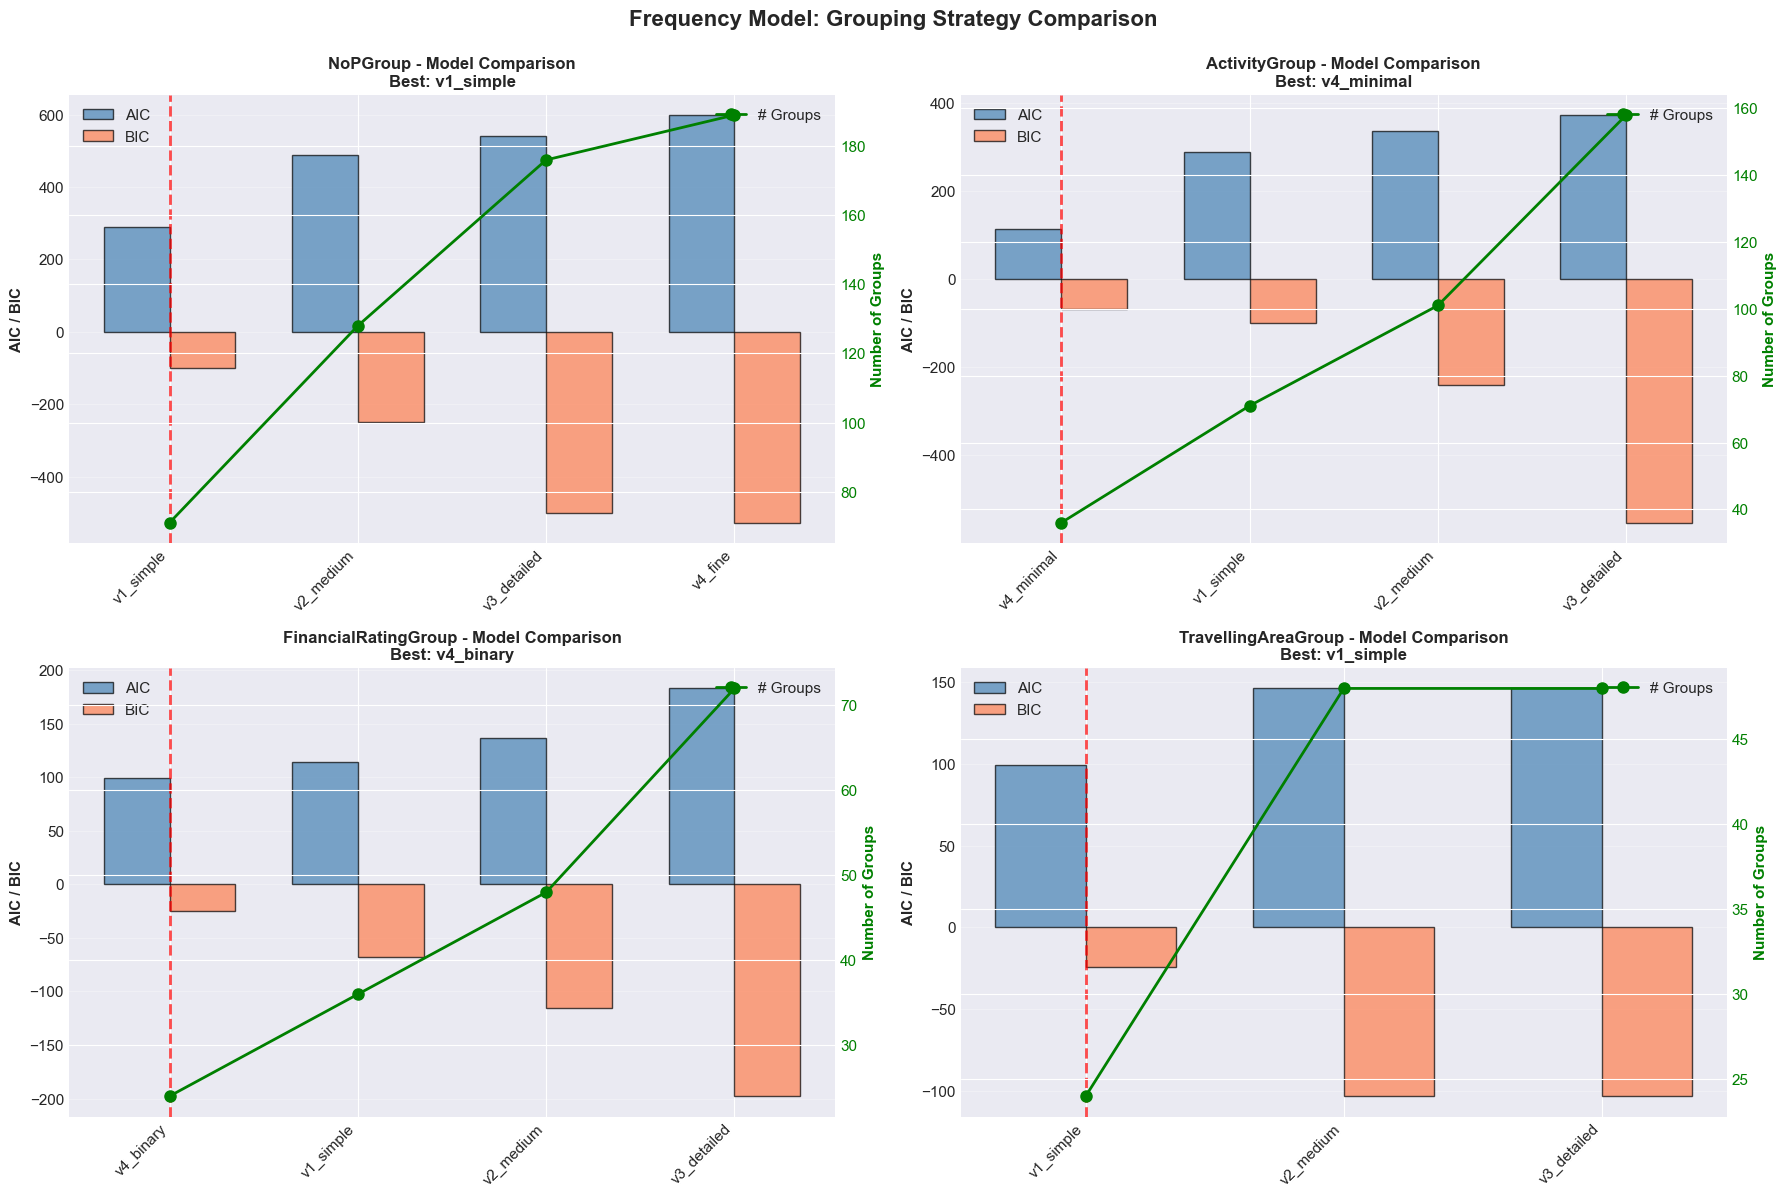

In [20]:
# Frequency model comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, var in enumerate(variables):
    var_data = results_freq[results_freq['variable'] == var].copy()
    var_data = var_data.sort_values('AIC')
    
    x = range(len(var_data))
    width = 0.35
    
    ax = axes[idx]
    ax2 = ax.twinx()
    
    # AIC bars
    bars1 = ax.bar([i - width/2 for i in x], var_data['AIC'], width, 
                    label='AIC', color='steelblue', alpha=0.7, edgecolor='black')
    
    # BIC bars
    bars2 = ax.bar([i + width/2 for i in x], var_data['BIC'], width,
                    label='BIC', color='coral', alpha=0.7, edgecolor='black')
    
    # Number of groups line
    line = ax2.plot(x, var_data['n_groups'], 'go-', linewidth=2, markersize=8, label='# Groups')
    
    # Highlight best
    best_strategy = best_config_freq[var]
    best_idx = var_data[var_data['strategy'] == best_strategy].index[0]
    best_pos = list(var_data.index).index(best_idx)
    ax.axvline(best_pos, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    ax.set_xticks(x)
    ax.set_xticklabels(var_data['strategy'], rotation=45, ha='right')
    ax.set_ylabel('AIC / BIC', fontweight='bold')
    ax2.set_ylabel('Number of Groups', fontweight='bold', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax.set_title(f'{var} - Model Comparison\nBest: {best_strategy}', fontweight='bold', fontsize=12)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Frequency Model: Grouping Strategy Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

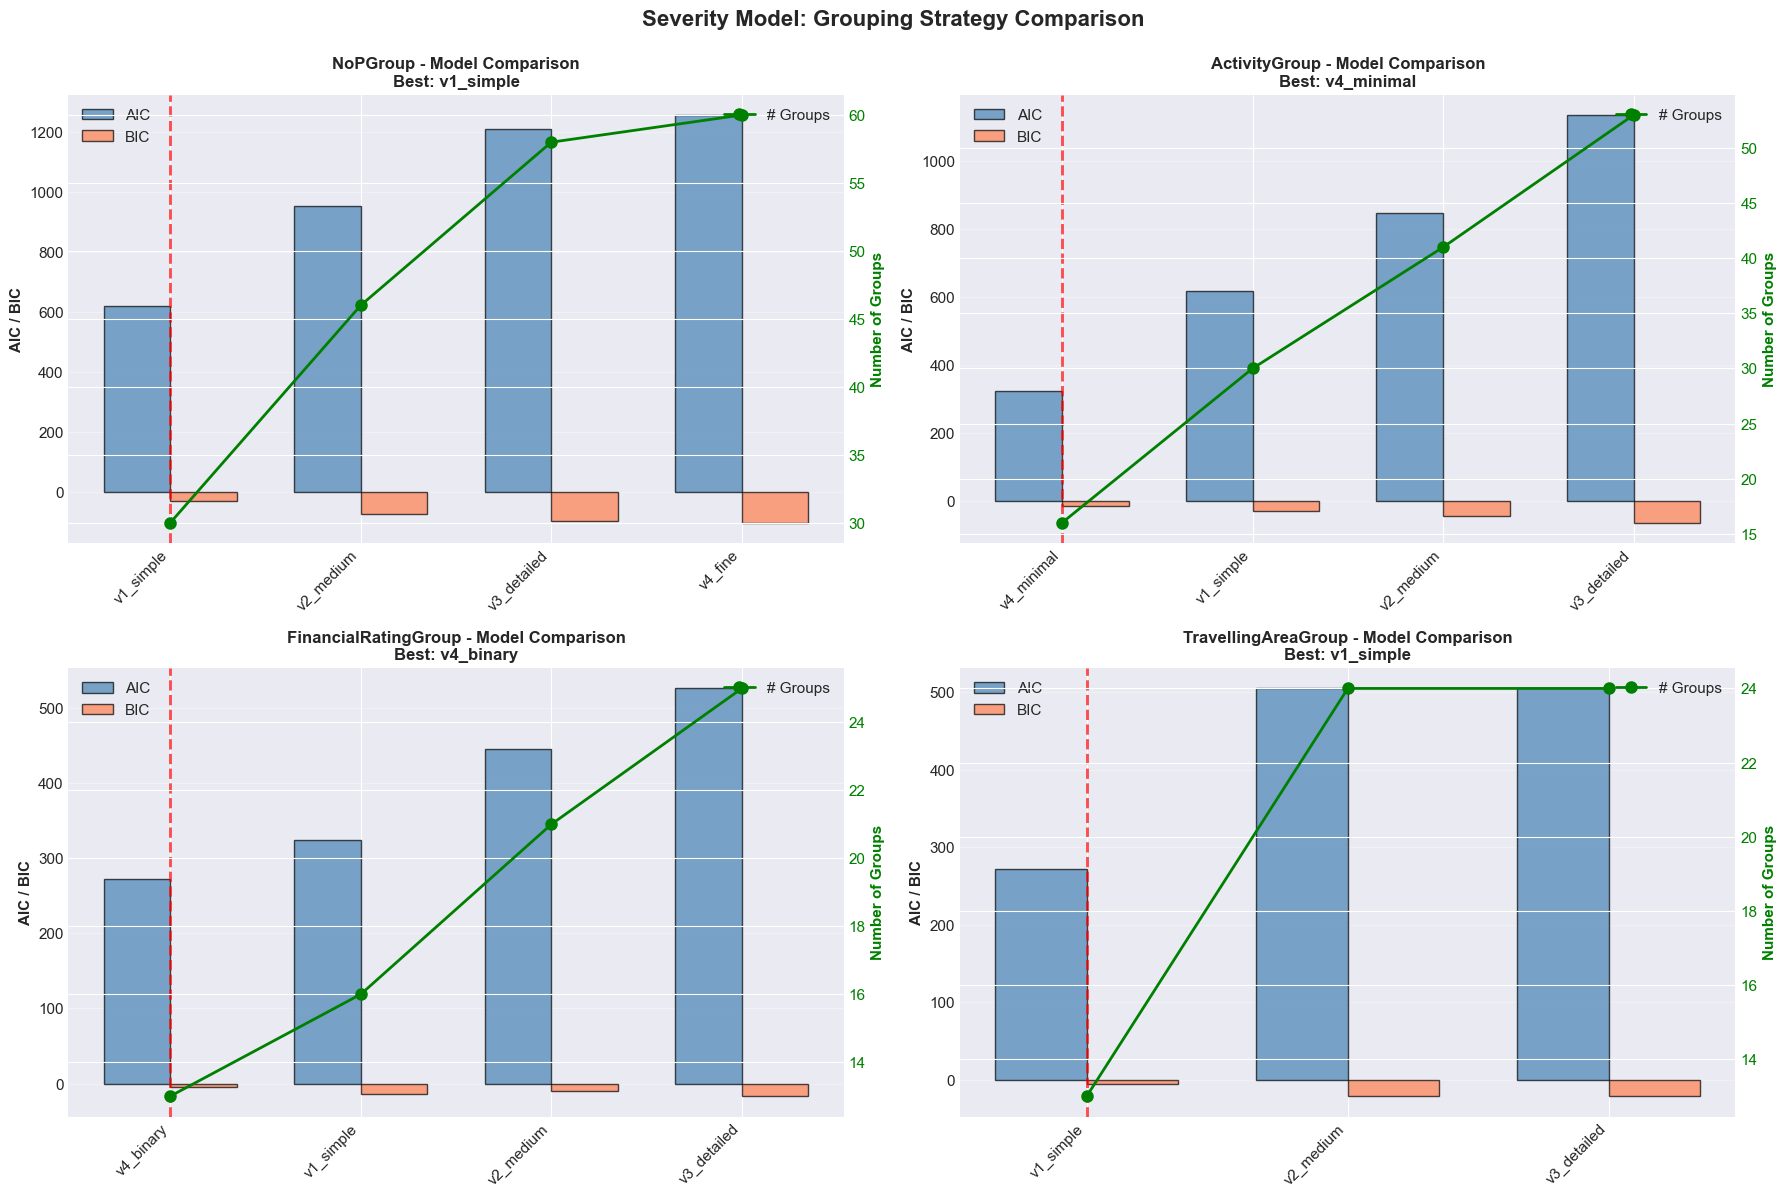

In [21]:
# Severity model comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, var in enumerate(variables):
    var_data = results_sev[results_sev['variable'] == var].copy()
    var_data = var_data.sort_values('AIC')
    
    x = range(len(var_data))
    width = 0.35
    
    ax = axes[idx]
    ax2 = ax.twinx()
    
    bars1 = ax.bar([i - width/2 for i in x], var_data['AIC'], width, 
                    label='AIC', color='steelblue', alpha=0.7, edgecolor='black')
    bars2 = ax.bar([i + width/2 for i in x], var_data['BIC'], width,
                    label='BIC', color='coral', alpha=0.7, edgecolor='black')
    line = ax2.plot(x, var_data['n_groups'], 'go-', linewidth=2, markersize=8, label='# Groups')
    
    best_strategy = best_config_sev[var]
    best_idx = var_data[var_data['strategy'] == best_strategy].index[0]
    best_pos = list(var_data.index).index(best_idx)
    ax.axvline(best_pos, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    ax.set_xticks(x)
    ax.set_xticklabels(var_data['strategy'], rotation=45, ha='right')
    ax.set_ylabel('AIC / BIC', fontweight='bold')
    ax2.set_ylabel('Number of Groups', fontweight='bold', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax.set_title(f'{var} - Model Comparison\nBest: {best_strategy}', fontweight='bold', fontsize=12)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Severity Model: Grouping Strategy Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 7. Final Models & Risk Factors

In [22]:
# Fit final models
df_train_freq = apply_grouping_config(df_train, best_config_freq)
final_model_freq, df_agg_freq, _ = fit_glm_model(df_train_freq, list(best_config_freq.keys()), model_type='frequency')

df_train_sev = apply_grouping_config(df_train, best_config_sev)
final_model_sev, df_agg_sev, _ = fit_glm_model(df_train_sev, list(best_config_sev.keys()), model_type='severity')

# Extract risk factors
def extract_risk_factors(model, df_grouped, variables):
    factors = {}
    for var in variables:
        params = model.params[model.params.index.str.contains(var)]
        if len(params) == 0:
            continue
        
        risk_factors = np.exp(params)
        risk_factors.index = (risk_factors.index.str.replace(".*[\)]", "", regex=True)
                             .str.replace("T.", "").str.replace("[", "").str.replace("]", ""))
        
        ref_cat = df_grouped.groupby(var, observed=True)['Duration'].sum().idxmax()
        risk_factors = pd.concat([risk_factors, pd.Series([1.0], index=[ref_cat])]).sort_index()
        factors[var] = risk_factors
    return factors

freq_factors = extract_risk_factors(final_model_freq, df_train_freq, list(best_config_freq.keys()))
sev_factors = extract_risk_factors(final_model_sev, df_train_sev, list(best_config_sev.keys()))

# Combine factors
combined_factors = {}
for var in freq_factors.keys():
    combined = pd.DataFrame({
        'Frequency': freq_factors[var],
        'Severity': sev_factors[var]
    })
    combined['Combined'] = combined['Frequency'] * combined['Severity']
    combined_factors[var] = combined

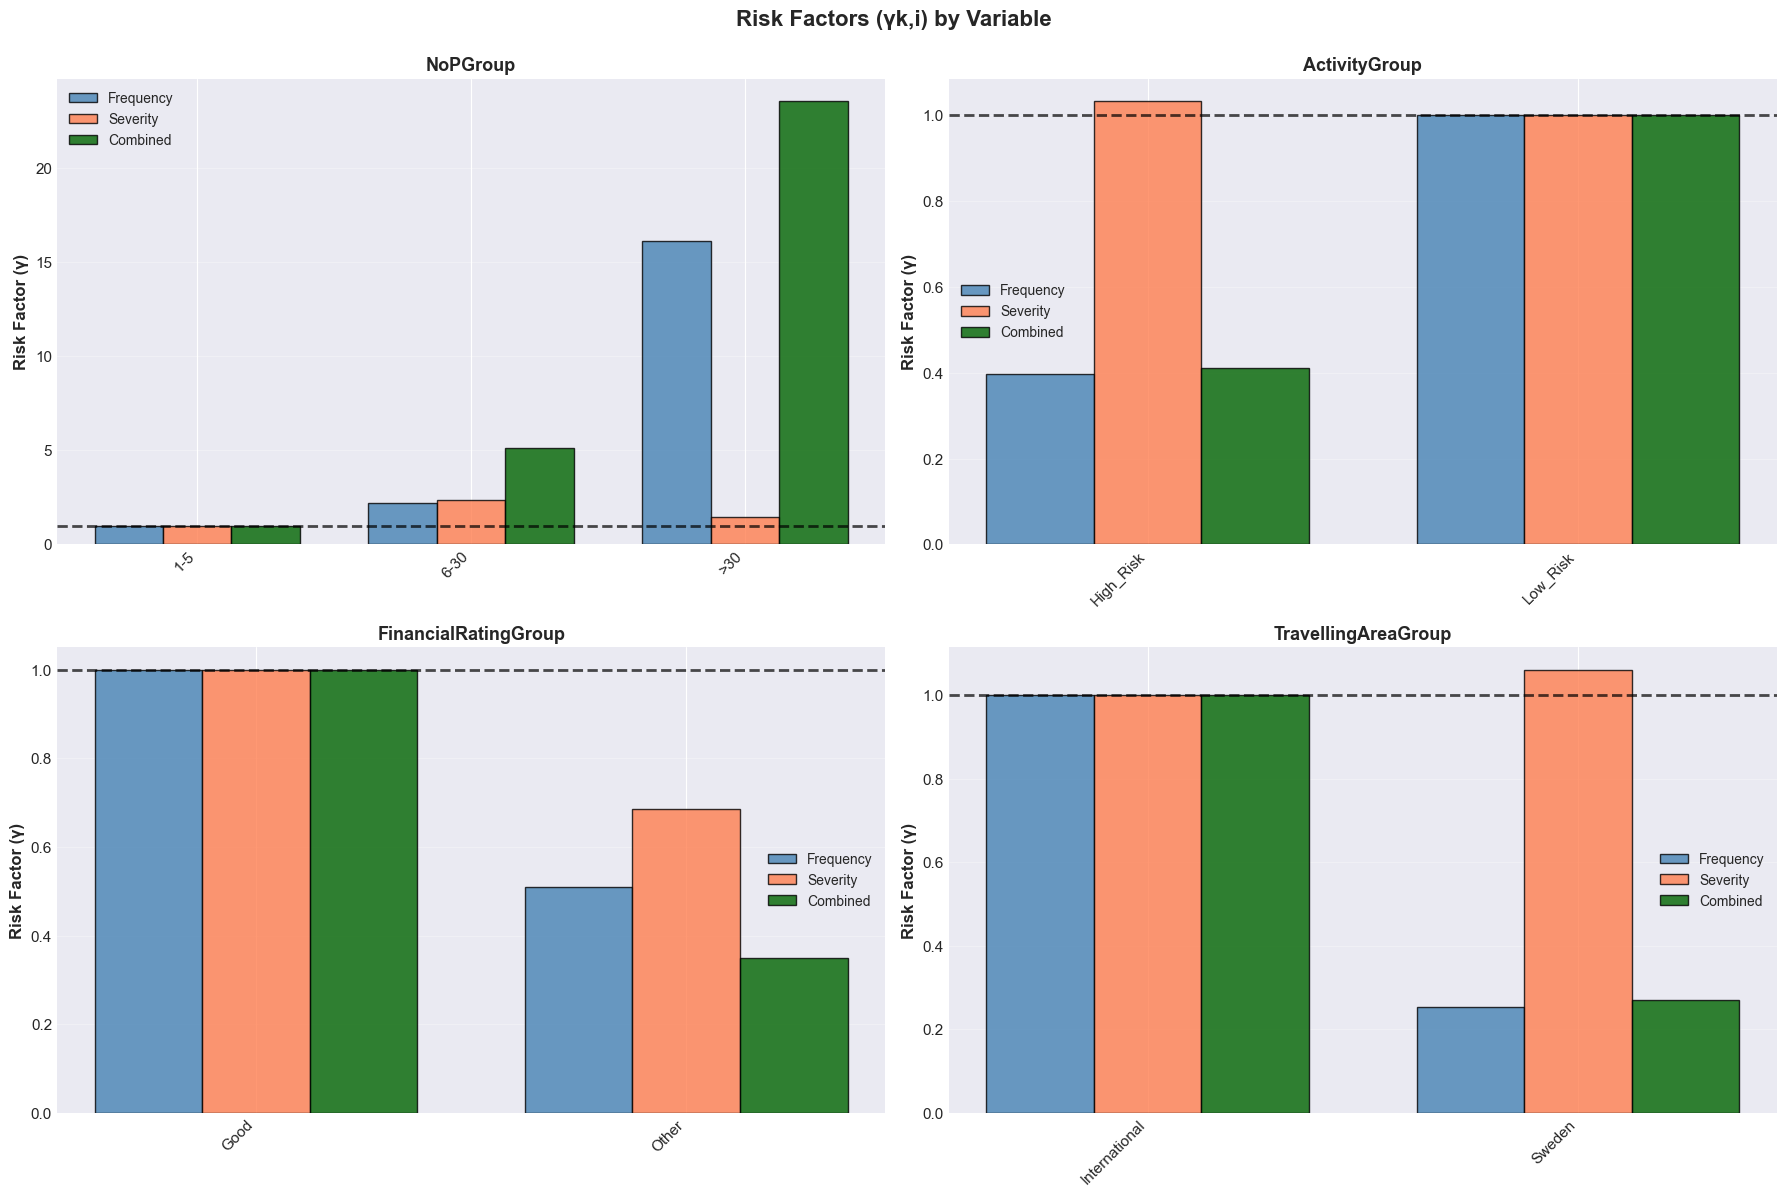

In [23]:
# Visualize risk factors
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, (var, factors) in enumerate(combined_factors.items()):
    ax = axes[idx]
    
    x = range(len(factors))
    width = 0.25
    
    ax.bar([i - width for i in x], factors['Frequency'], width, 
           label='Frequency', alpha=0.8, edgecolor='black', color='steelblue')
    ax.bar([i for i in x], factors['Severity'], width,
           label='Severity', alpha=0.8, edgecolor='black', color='coral')
    ax.bar([i + width for i in x], factors['Combined'], width,
           label='Combined', alpha=0.8, edgecolor='black', color='darkgreen')
    
    ax.axhline(y=1, color='black', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(factors.index, rotation=45, ha='right')
    ax.set_ylabel('Risk Factor (γ)', fontweight='bold', fontsize=12)
    ax.set_title(var, fontweight='bold', fontsize=13)
    ax.legend(loc='best', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Risk Factors (γk,i) by Variable', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 8. Likelihood Ratio Tests

In [24]:
def perform_lr_tests(df, config, model_type='frequency'):
    df_grouped = apply_grouping_config(df, config)
    full_model, _, _ = fit_glm_model(df_grouped, list(config.keys()), model_type=model_type)
    
    lr_results = []
    for var in config.keys():
        reduced_config = {k: v for k, v in config.items() if k != var}
        df_reduced = apply_grouping_config(df, reduced_config)
        reduced_model, _, _ = fit_glm_model(df_reduced, list(reduced_config.keys()), model_type=model_type)
        
        lr_stat, p_value, df_diff = likelihood_ratio_test(reduced_model, full_model)
        
        lr_results.append({
            'Variable': var,
            'LR_Stat': lr_stat,
            'df': df_diff,
            'p_value': p_value,
            'Significant': p_value < 0.05,
            'Delta_AIC': reduced_model.aic - full_model.aic
        })
    
    return pd.DataFrame(lr_results), full_model

lr_freq, full_freq = perform_lr_tests(df_train, best_config_freq, 'frequency')
lr_sev, full_sev = perform_lr_tests(df_train, best_config_sev, 'severity')

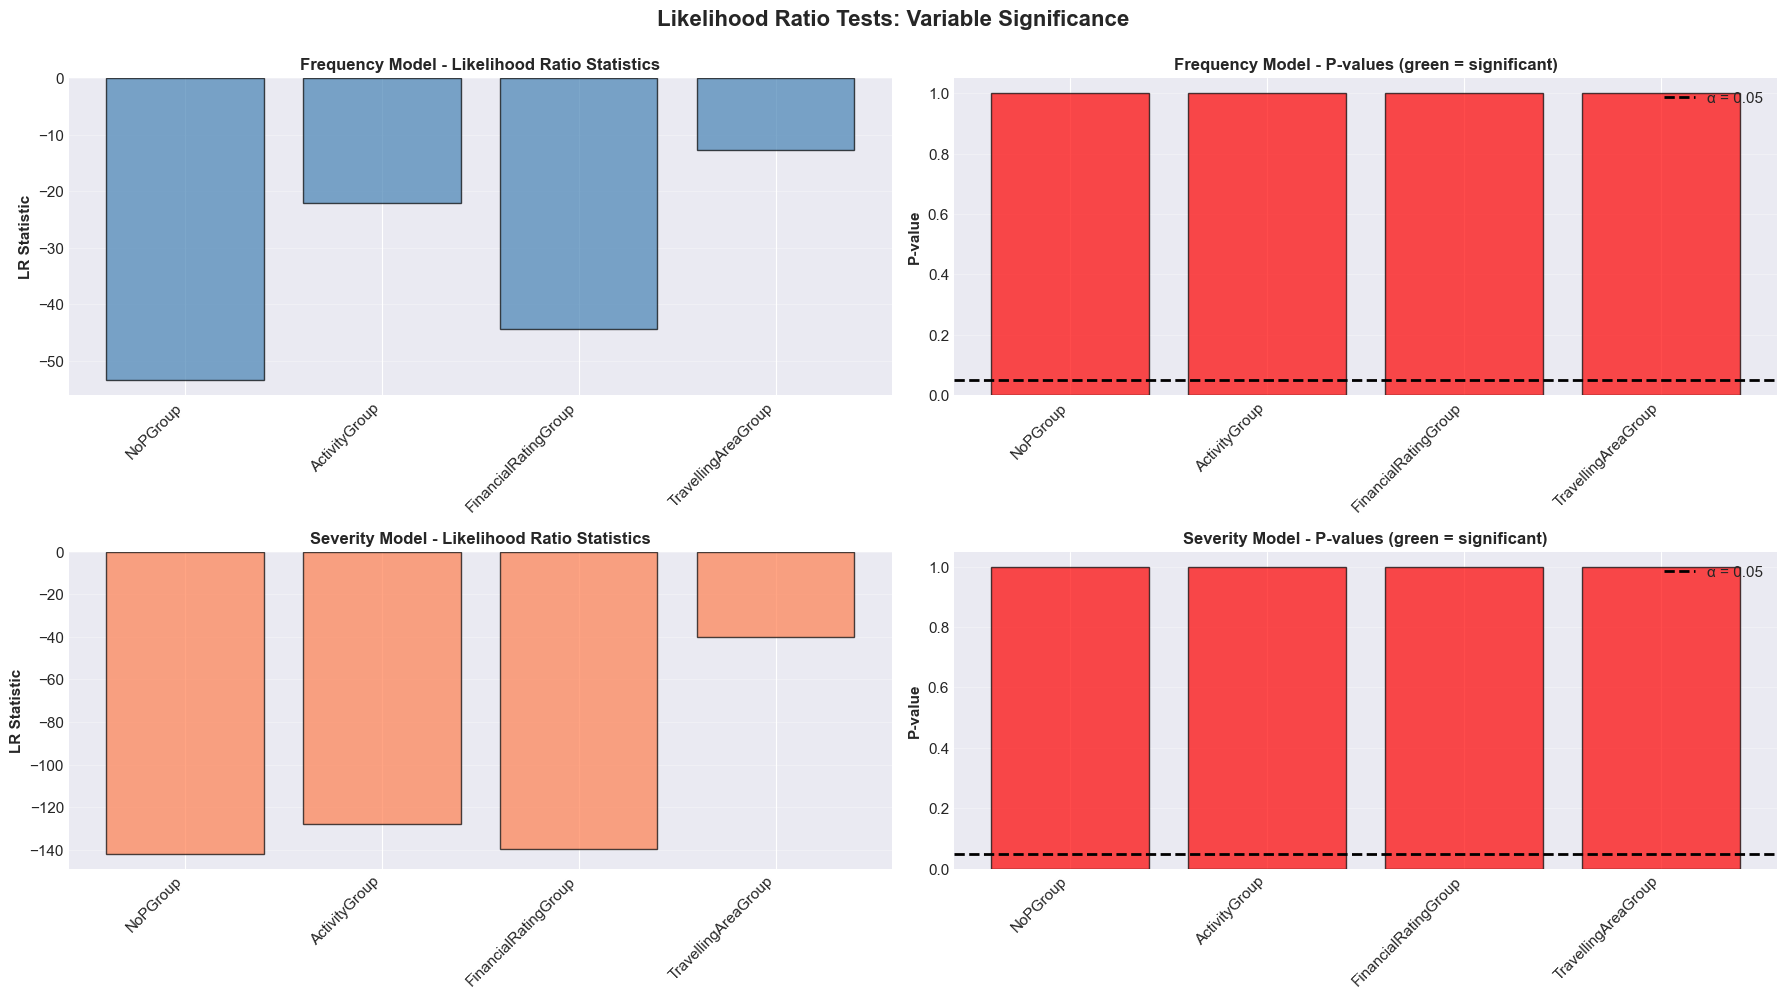

In [25]:
# Visualize LR tests
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Frequency - LR Statistics
axes[0, 0].bar(range(len(lr_freq)), lr_freq['LR_Stat'], color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xticks(range(len(lr_freq)))
axes[0, 0].set_xticklabels(lr_freq['Variable'], rotation=45, ha='right')
axes[0, 0].set_ylabel('LR Statistic', fontweight='bold')
axes[0, 0].set_title('Frequency Model - Likelihood Ratio Statistics', fontweight='bold', fontsize=12)
axes[0, 0].grid(axis='y', alpha=0.3)

# Frequency - P-values
colors = ['green' if sig else 'red' for sig in lr_freq['Significant']]
axes[0, 1].bar(range(len(lr_freq)), lr_freq['p_value'], color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].axhline(0.05, color='black', linestyle='--', linewidth=2, label='α = 0.05')
axes[0, 1].set_xticks(range(len(lr_freq)))
axes[0, 1].set_xticklabels(lr_freq['Variable'], rotation=45, ha='right')
axes[0, 1].set_ylabel('P-value', fontweight='bold')
axes[0, 1].set_title('Frequency Model - P-values (green = significant)', fontweight='bold', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Severity - LR Statistics
axes[1, 0].bar(range(len(lr_sev)), lr_sev['LR_Stat'], color='coral', alpha=0.7, edgecolor='black')
axes[1, 0].set_xticks(range(len(lr_sev)))
axes[1, 0].set_xticklabels(lr_sev['Variable'], rotation=45, ha='right')
axes[1, 0].set_ylabel('LR Statistic', fontweight='bold')
axes[1, 0].set_title('Severity Model - Likelihood Ratio Statistics', fontweight='bold', fontsize=12)
axes[1, 0].grid(axis='y', alpha=0.3)

# Severity - P-values
colors = ['green' if sig else 'red' for sig in lr_sev['Significant']]
axes[1, 1].bar(range(len(lr_sev)), lr_sev['p_value'], color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].axhline(0.05, color='black', linestyle='--', linewidth=2, label='α = 0.05')
axes[1, 1].set_xticks(range(len(lr_sev)))
axes[1, 1].set_xticklabels(lr_sev['Variable'], rotation=45, ha='right')
axes[1, 1].set_ylabel('P-value', fontweight='bold')
axes[1, 1].set_title('Severity Model - P-values (green = significant)', fontweight='bold', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Likelihood Ratio Tests: Variable Significance', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 9. Test Set Validation

In [26]:
# Apply groupings to test data and aggregate
df_test_freq = apply_grouping_config(df_test, best_config_freq)
df_test_sev = apply_grouping_config(df_test, best_config_sev)

# Aggregate test data by groups
test_vars_freq = list(best_config_freq.keys())
df_test_agg_freq = (df_test_freq[test_vars_freq + ['Duration', 'NumberOfClaims', 'ClaimCost']]
                    .groupby(test_vars_freq, observed=True)
                    .agg('sum')
                    .reset_index())

df_test_agg_sev = (df_test_sev[test_vars_freq + ['Duration', 'NumberOfClaims', 'ClaimCost']]
                   .groupby(test_vars_freq, observed=True)
                   .agg('sum')
                   .reset_index())

df_test_agg_sev['AvgClaimCost'] = df_test_agg_sev['ClaimCost'] / df_test_agg_sev['NumberOfClaims']

# Get predictions on aggregated data
try:
    pred_freq_agg = final_model_freq.predict(df_test_agg_freq)
    df_test_agg_freq['PredFreq'] = pred_freq_agg
    df_test_agg_freq['ActualFreq'] = df_test_agg_freq['NumberOfClaims'] / df_test_agg_freq['Duration']
    freq_success = True
except Exception as e:
    print(f"Frequency prediction error: {e}")
    freq_success = False

try:
    df_test_agg_sev_claims = df_test_agg_sev[df_test_agg_sev['NumberOfClaims'] > 0].copy()
    pred_sev_agg = final_model_sev.predict(df_test_agg_sev_claims)
    df_test_agg_sev_claims['PredSev'] = pred_sev_agg
    df_test_agg_sev_claims['ActualSev'] = df_test_agg_sev_claims['AvgClaimCost']
    sev_success = True
except Exception as e:
    print(f"Severity prediction error: {e}")
    sev_success = False

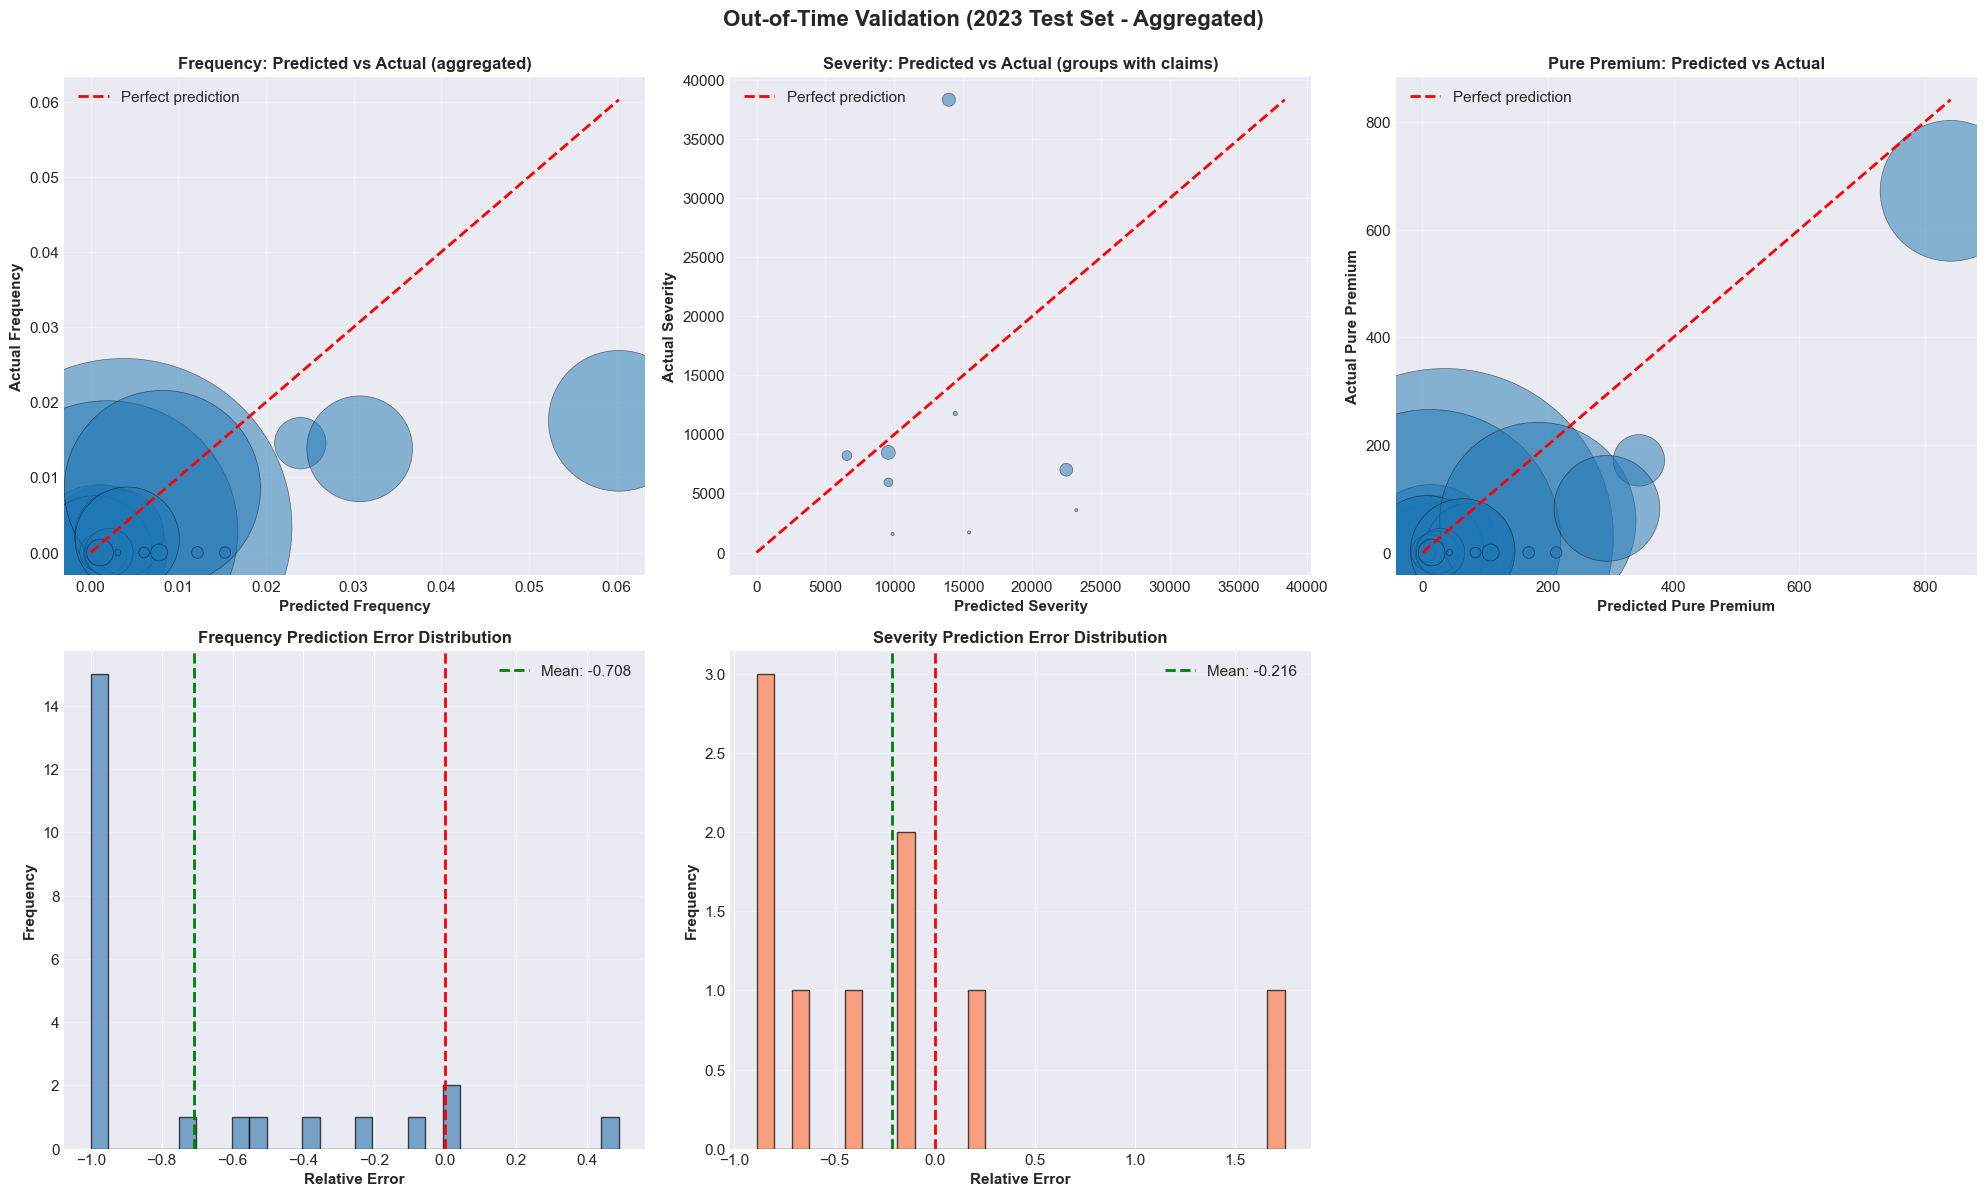

In [30]:
# Validation plots - SIMPLIFIED
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

if freq_success:
    # Frequency scatter - simple uniform points
    axes[0, 0].scatter(df_test_agg_freq['PredFreq'], df_test_agg_freq['ActualFreq'], 
                      s=60, alpha=0.6, color='steelblue', edgecolors='black', linewidths=1)
    max_freq = max(df_test_agg_freq['PredFreq'].max(), df_test_agg_freq['ActualFreq'].max())
    axes[0, 0].plot([0, max_freq], [0, max_freq], 'r--', linewidth=2, label='Perfect prediction')
    axes[0, 0].set_xlabel('Predicted Frequency', fontweight='bold', fontsize=12)
    axes[0, 0].set_ylabel('Actual Frequency', fontweight='bold', fontsize=12)
    axes[0, 0].set_title('Frequency: Predicted vs Actual', fontweight='bold', fontsize=13)
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(alpha=0.3)
else:
    axes[0, 0].text(0.5, 0.5, 'Frequency prediction failed\n(groups in test not in train)', 
                   ha='center', va='center', transform=axes[0, 0].transAxes, fontsize=13, color='red')
    axes[0, 0].set_title('Frequency: Predicted vs Actual', fontweight='bold', fontsize=13)

if sev_success:
    # Severity scatter - simple uniform points
    axes[0, 1].scatter(df_test_agg_sev_claims['PredSev'], df_test_agg_sev_claims['ActualSev'],
                      s=60, alpha=0.6, color='coral', edgecolors='black', linewidths=1)
    max_sev = max(df_test_agg_sev_claims['PredSev'].max(), df_test_agg_sev_claims['ActualSev'].max())
    axes[0, 1].plot([0, max_sev], [0, max_sev], 'r--', linewidth=2, label='Perfect prediction')
    axes[0, 1].set_xlabel('Predicted Severity', fontweight='bold', fontsize=12)
    axes[0, 1].set_ylabel('Actual Severity', fontweight='bold', fontsize=12)
    axes[0, 1].set_title('Severity: Predicted vs Actual', fontweight='bold', fontsize=13)
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'Severity prediction failed\n(groups in test not in train)', 
                   ha='center', va='center', transform=axes[0, 1].transAxes, fontsize=13, color='red')
    axes[0, 1].set_title('Severity: Predicted vs Actual', fontweight='bold', fontsize=13)

if freq_success and sev_success:
    # Pure premium (merge predictions) - simple uniform points
    df_test_combined = df_test_agg_freq.copy()
    sev_dict = df_test_agg_sev_claims.set_index(test_vars_freq)['PredSev'].to_dict()
    
    def get_sev(row):
        key = tuple(row[v] for v in test_vars_freq)
        return sev_dict.get(key, df_test_agg_sev_claims['PredSev'].mean())
    
    df_test_combined['PredSev'] = df_test_combined.apply(get_sev, axis=1)
    df_test_combined['PredPurePremium'] = df_test_combined['PredFreq'] * df_test_combined['PredSev']
    df_test_combined['ActualPurePremium'] = df_test_combined['ClaimCost'] / df_test_combined['Duration']
    
    axes[0, 2].scatter(df_test_combined['PredPurePremium'], df_test_combined['ActualPurePremium'],
                      s=60, alpha=0.6, color='darkgreen', edgecolors='black', linewidths=1)
    max_pp = max(df_test_combined['PredPurePremium'].max(), df_test_combined['ActualPurePremium'].max())
    axes[0, 2].plot([0, max_pp], [0, max_pp], 'r--', linewidth=2, label='Perfect prediction')
    axes[0, 2].set_xlabel('Predicted Pure Premium', fontweight='bold', fontsize=12)
    axes[0, 2].set_ylabel('Actual Pure Premium', fontweight='bold', fontsize=12)
    axes[0, 2].set_title('Pure Premium: Predicted vs Actual', fontweight='bold', fontsize=13)
    axes[0, 2].legend(fontsize=11)
    axes[0, 2].grid(alpha=0.3)
else:
    axes[0, 2].text(0.5, 0.5, 'Pure premium requires both\nfrequency and severity', 
                   ha='center', va='center', transform=axes[0, 2].transAxes, fontsize=13, color='orange')
    axes[0, 2].set_title('Pure Premium: Predicted vs Actual', fontweight='bold', fontsize=13)

# Error distributions
if freq_success:
    freq_errors = (df_test_agg_freq['ActualFreq'] - df_test_agg_freq['PredFreq']) / df_test_agg_freq['PredFreq']
    freq_errors_clean = freq_errors[freq_errors.abs() < 5]
    axes[1, 0].hist(freq_errors_clean, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].axvline(freq_errors_clean.mean(), color='green', linestyle='--', linewidth=2, 
                      label=f'Mean: {freq_errors_clean.mean():.3f}')
    axes[1, 0].set_xlabel('Relative Error', fontweight='bold')
    axes[1, 0].set_ylabel('Frequency', fontweight='bold')
    axes[1, 0].set_title('Frequency Prediction Error Distribution', fontweight='bold', fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
else:
    axes[1, 0].axis('off')

if sev_success:
    sev_errors = (df_test_agg_sev_claims['ActualSev'] - df_test_agg_sev_claims['PredSev']) / df_test_agg_sev_claims['PredSev']
    sev_errors_clean = sev_errors[sev_errors.abs() < 5]
    axes[1, 1].hist(sev_errors_clean, bins=30, edgecolor='black', alpha=0.7, color='coral')
    axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 1].axvline(sev_errors_clean.mean(), color='green', linestyle='--', linewidth=2,
                      label=f'Mean: {sev_errors_clean.mean():.3f}')
    axes[1, 1].set_xlabel('Relative Error', fontweight='bold')
    axes[1, 1].set_ylabel('Frequency', fontweight='bold')
    axes[1, 1].set_title('Severity Prediction Error Distribution', fontweight='bold', fontsize=12)
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)
else:
    axes[1, 1].axis('off')

# Summary metrics
axes[1, 2].axis('off')
if freq_success:
    total_pred_claims = (df_test_agg_freq['PredFreq'] * df_test_agg_freq['Duration']).sum()
    total_actual_claims = df_test_agg_freq['NumberOfClaims'].sum()
    ratio_claims = total_actual_claims / total_pred_claims if total_pred_claims > 0 else 0
else:
    total_pred_claims = 0
    total_actual_claims = df_test['NumberOfClaims'].sum()
    ratio_claims = 0

if freq_success and sev_success:
    total_pred_cost = (df_test_combined['PredPurePremium'] * df_test_combined['Duration']).sum()
    total_actual_cost = df_test_combined['ClaimCost'].sum()
    ratio_cost = total_actual_cost / total_pred_cost if total_pred_cost > 0 else 0
else:
    total_pred_cost = 0
    total_actual_cost = df_test['ClaimCost'].sum()
    ratio_cost = 0



plt.suptitle('Out-of-Time Validation (2023 Test Set - Aggregated)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 10. Calculate Base Premium (Leveling)

In [31]:
def calculate_gamma_0_from_training(df_train, combined_factors, best_config, target_ratio=0.90):
    """
    Calculate gamma_0 using TRAINING data to avoid missing groups.
    This represents the base premium calibrated on known groups.
    """
    # Apply grouping on training data
    df_grouped = apply_grouping_config(df_train, best_config)
    
    # Aggregate by groups
    test_vars = list(best_config.keys())
    df_agg = (df_grouped[test_vars + ['Duration', 'NumberOfClaims', 'ClaimCost']]
              .groupby(test_vars, observed=True)
              .agg('sum')
              .reset_index())
    
    # Get predictions on aggregated training data
    pred_freq_agg = final_model_freq.predict(df_agg)
    
    df_agg_sev = df_agg[df_agg['NumberOfClaims'] > 0].copy()
    df_agg_sev['AvgClaimCost'] = df_agg_sev['ClaimCost'] / df_agg_sev['NumberOfClaims']
    pred_sev_agg = final_model_sev.predict(df_agg_sev)
    
    # Merge predictions back
    df_agg['PredFreq'] = pred_freq_agg
    
    # Add severity predictions
    sev_dict = dict(zip(
        [tuple(row[v] for v in test_vars) for _, row in df_agg_sev.iterrows()],
        pred_sev_agg
    ))
    
    def get_pred_sev(row):
        key = tuple(row[v] for v in test_vars)
        return sev_dict.get(key, pred_sev_agg.mean())
    
    df_agg['PredSev'] = df_agg.apply(get_pred_sev, axis=1)
    
    # Step 1: Expected cost for full year
    df_agg['ExpectedCostPerYear'] = df_agg['PredFreq'] * df_agg['PredSev'] * df_agg['Duration']
    total_expected_cost = df_agg['ExpectedCostPerYear'].sum()
    
    # Step 2: Target premium
    target_premium_total = total_expected_cost / target_ratio
    
    # Step 3: Calculate risk factors per group
    def get_combined_risk_factor(row, factors_dict, config):
        total = 1.0
        for var in config.keys():
            group = row[var]
            total *= factors_dict[var].loc[group, 'Combined']
        return total
    
    df_agg['RiskFactor'] = df_agg.apply(
        lambda row: get_combined_risk_factor(row, combined_factors, best_config), axis=1
    )
    
    # Weight risk factors by duration (exposure)
    df_agg['WeightedRiskFactor'] = df_agg['RiskFactor'] * df_agg['Duration']
    total_risk_factor = df_agg['WeightedRiskFactor'].sum()
    
    # Step 4: Calculate γ₀
    gamma_0 = target_premium_total / total_risk_factor if total_risk_factor > 0 else 1000
    
    # Verification: calculate premiums
    df_agg['Premium'] = gamma_0 * df_agg['WeightedRiskFactor']
    
    return gamma_0, df_agg, total_expected_cost, target_premium_total

# Calculate gamma_0 using TRAINING data
gamma_0, df_leveling, exp_cost, target_prem = calculate_gamma_0_from_training(
    df_train, combined_factors, best_config_freq, target_ratio=0.90
)

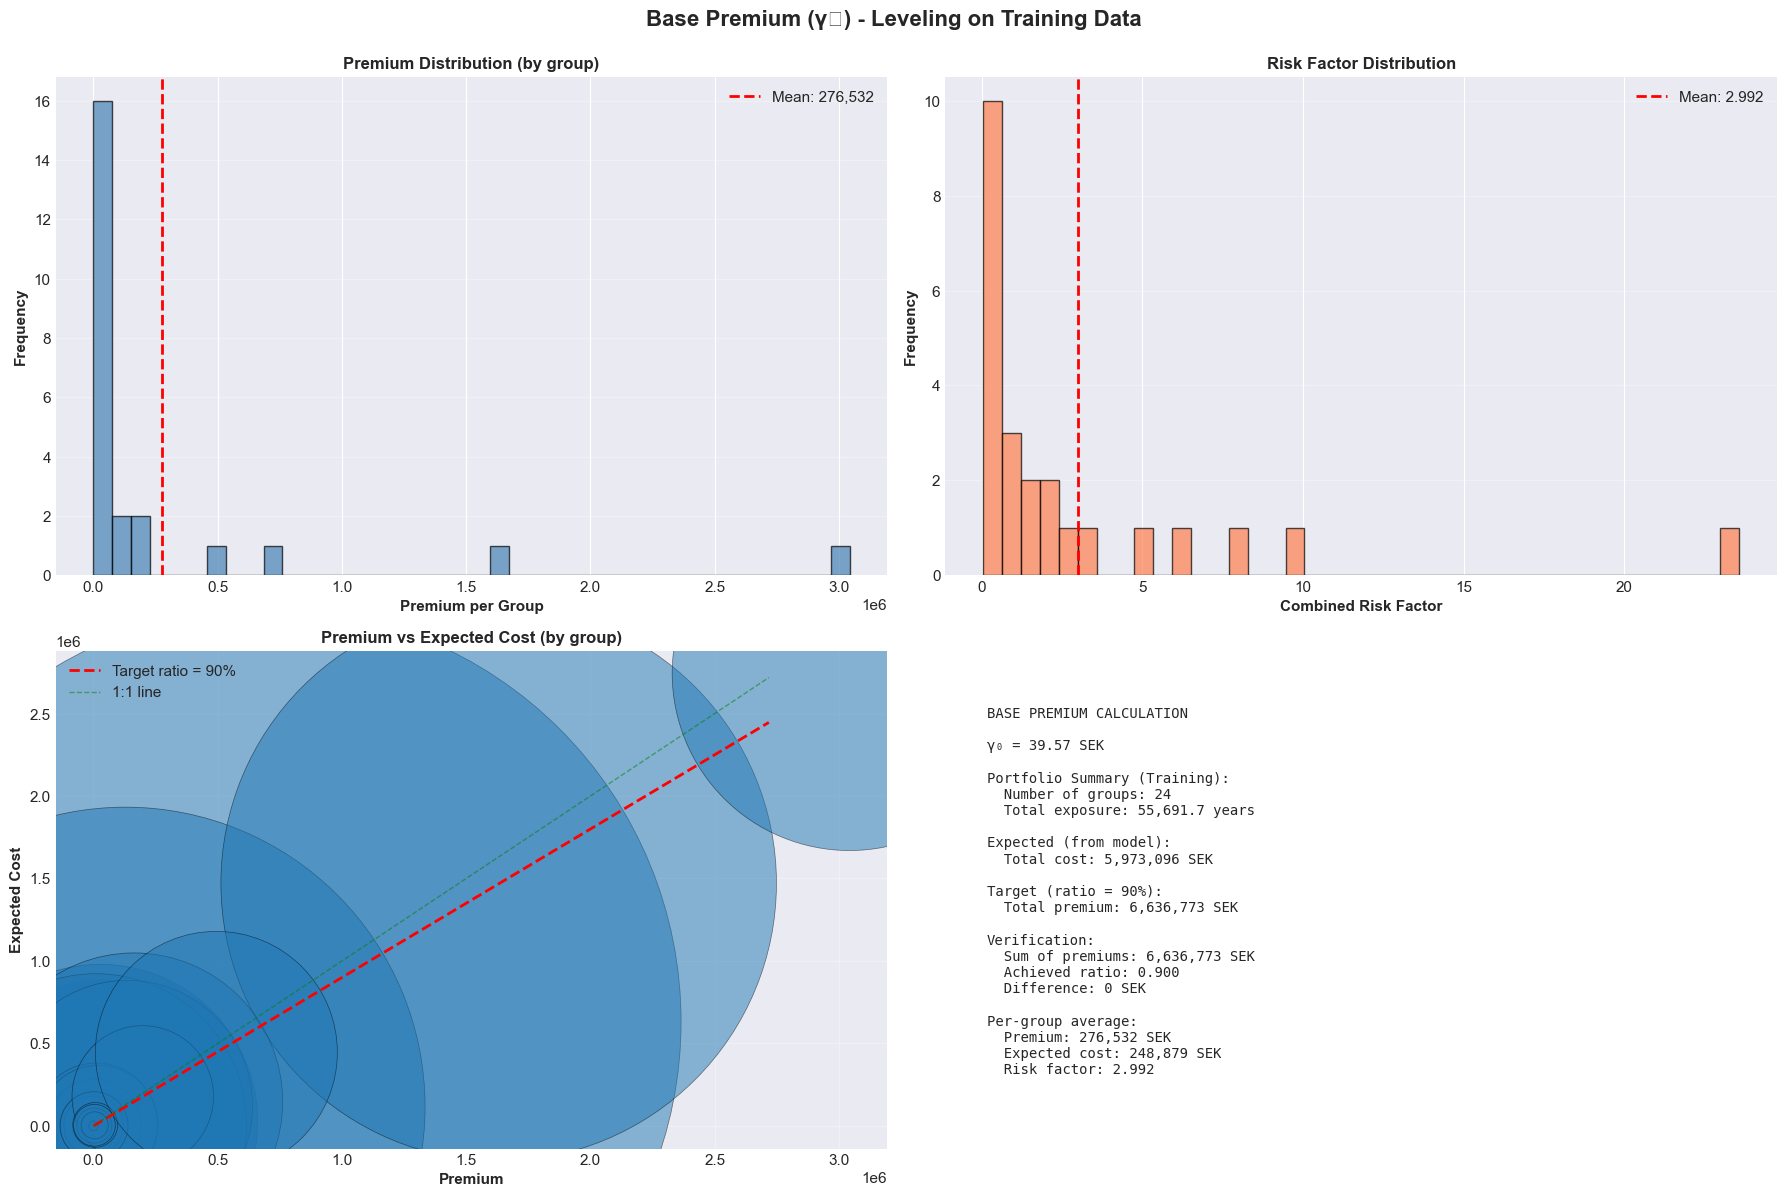

In [ ]:
# Leveling visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Premium distribution by group
axes[0, 0].hist(df_leveling['Premium'], bins=40, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(df_leveling['Premium'].mean(), color='red', linestyle='--', linewidth=2,label=f"Mean: {df_leveling['Premium'].mean():,.0f}")
axes[0, 0].set_xlabel('Premium per Group', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Premium Distribution (by group)', fontweight='bold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Risk factor distribution
axes[0, 1].hist(df_leveling['RiskFactor'], bins=40, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(df_leveling['RiskFactor'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df_leveling['RiskFactor'].mean():.3f}")
axes[0, 1].set_xlabel('Combined Risk Factor', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Risk Factor Distribution', fontweight='bold', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Premium vs Expected Cost - simple uniform points
axes[1, 0].scatter(df_leveling['Premium'], df_leveling['ExpectedCostPerYear'], 
                  s=60, alpha=0.6, color='purple', edgecolors='black', linewidths=1)
max_val = max(df_leveling['Premium'].quantile(0.99), df_leveling['ExpectedCostPerYear'].quantile(0.99))
axes[1, 0].plot([0, max_val], [0, max_val * 0.9], 'r--', linewidth=2, label='Target ratio = 90%')
axes[1, 0].plot([0, max_val], [0, max_val], 'g--', linewidth=1, alpha=0.5, label='1:1 line')
axes[1, 0].set_xlabel('Premium', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Expected Cost', fontweight='bold', fontsize=12)
axes[1, 0].set_title('Premium vs Expected Cost', fontweight='bold', fontsize=13)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

# Summary
axes[1, 1].axis('off')
achieved_ratio = exp_cost / df_leveling['Premium'].sum() if df_leveling['Premium'].sum() > 0 else 0
n_groups = len(df_leveling)
total_duration = df_leveling['Duration'].sum()

leveling_summary = f"""BASE PREMIUM CALCULATION

γ₀ = {gamma_0:,.2f} SEK

Portfolio Summary (Training):
  Number of groups: {n_groups}
  Total exposure: {total_duration:,.1f} years
  
Expected (from model):
  Total cost: {exp_cost:,.0f} SEK
  
Target (ratio = 90%):
  Total premium: {target_prem:,.0f} SEK
  
Verification:
  Sum of premiums: {df_leveling['Premium'].sum():,.0f} SEK
  Achieved ratio: {achieved_ratio:.3f}
  Difference: {abs(df_leveling['Premium'].sum() - target_prem):,.0f} SEK
  
Per-group average:
  Premium: {df_leveling['Premium'].mean():,.0f} SEK
  Expected cost: {df_leveling['ExpectedCostPerYear'].mean():,.0f} SEK
  Risk factor: {df_leveling['RiskFactor'].mean():.3f}
"""
axes[1, 1].text(0.05, 0.5, leveling_summary, fontsize=10, family='monospace', verticalalignment='center')

plt.suptitle('Base Premium (γ₀) - Leveling on Training Data', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 11. Final Summary & Export

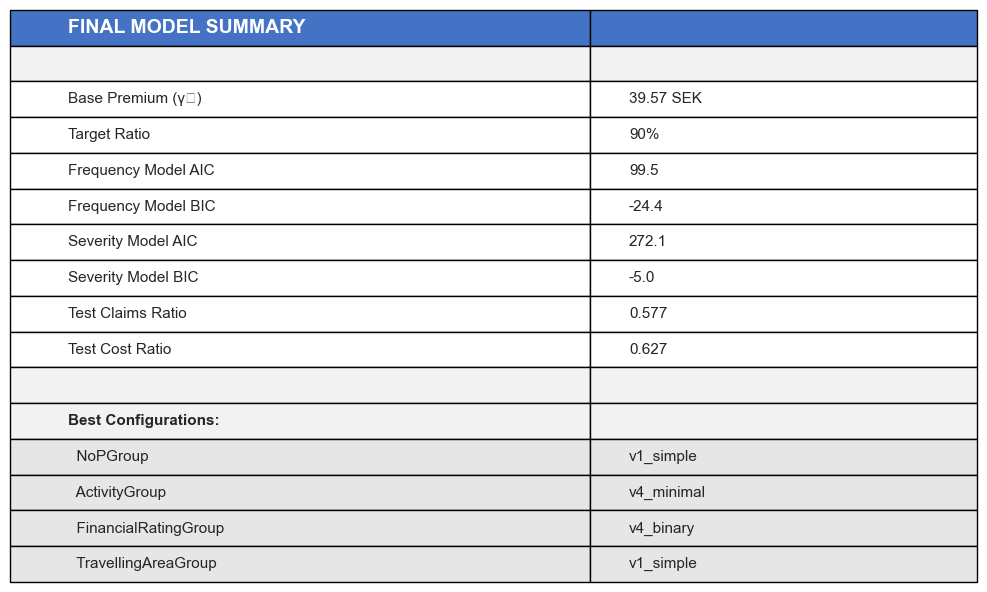

In [36]:
# Summary table
# Calculate test ratios if available
if freq_success:
    test_claims_total_pred = (df_test_agg_freq['PredFreq'] * df_test_agg_freq['Duration']).sum()
    test_claims_total_actual = df_test_agg_freq['NumberOfClaims'].sum()
    test_claims_ratio = test_claims_total_actual / test_claims_total_pred if test_claims_total_pred > 0 else 0
else:
    test_claims_ratio = 0

if freq_success and sev_success:
    test_cost_total_pred = (df_test_combined['PredPurePremium'] * df_test_combined['Duration']).sum()
    test_cost_total_actual = df_test_combined['ClaimCost'].sum()
    test_cost_ratio = test_cost_total_actual / test_cost_total_pred if test_cost_total_pred > 0 else 0
else:
    test_cost_ratio = 0

summary_data = {
    'Metric': [
        'Base Premium (γ₀)',
        'Target Ratio',
        'Frequency Model AIC',
        'Frequency Model BIC',
        'Severity Model AIC',
        'Severity Model BIC',
        'Test Claims Ratio',
        'Test Cost Ratio'
    ],
    'Value': [
        f'{gamma_0:,.2f} SEK',
        '90%',
        f'{full_freq.aic:.1f}',
        f'{full_freq.bic:.1f}',
        f'{full_sev.aic:.1f}',
        f'{full_sev.bic:.1f}',
        f'{test_claims_ratio:.3f}' if test_claims_ratio > 0 else 'N/A',
        f'{test_cost_ratio:.3f}' if test_cost_ratio > 0 else 'N/A'
    ]
}

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

table_data = []
table_data.append(['FINAL MODEL SUMMARY', ''])
table_data.append(['', ''])
for metric, value in zip(summary_data['Metric'], summary_data['Value']):
    table_data.append([metric, value])
table_data.append(['', ''])
table_data.append(['Best Configurations:', ''])
for var, strat in best_config_freq.items():
    table_data.append([f'  {var}', strat])

table = ax.table(cellText=table_data, cellLoc='left', loc='center',
                colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

for i in range(len(table_data)):
    if i == 0:
        table[(i, 0)].set_facecolor('#4472C4')
        table[(i, 1)].set_facecolor('#4472C4')
        table[(i, 0)].set_text_props(weight='bold', color='white', size=14)
        table[(i, 1)].set_text_props(weight='bold', color='white', size=14)
    elif table_data[i][0].startswith('  '):
        table[(i, 0)].set_facecolor('#E7E6E6')
        table[(i, 1)].set_facecolor('#E7E6E6')
    elif table_data[i][0] in ['Best Configurations:', '']:
        table[(i, 0)].set_facecolor('#F2F2F2')
        table[(i, 1)].set_facecolor('#F2F2F2')
        if table_data[i][0] == 'Best Configurations:':
            table[(i, 0)].set_text_props(weight='bold')

plt.tight_layout()
plt.show()

# Export results
for var, factors in combined_factors.items():
    factors.to_csv(f'risk_factors_{var}.csv')

results_freq.to_csv('model_selection_frequency.csv', index=False)
results_sev.to_csv('model_selection_severity.csv', index=False)
lr_freq.to_csv('likelihood_ratio_tests_frequency.csv', index=False)
lr_sev.to_csv('likelihood_ratio_tests_severity.csv', index=False)

pd.DataFrame([{
    'gamma_0': gamma_0,
    'target_ratio': 0.90,
    'freq_aic': full_freq.aic,
    'freq_bic': full_freq.bic,
    'sev_aic': full_sev.aic,
    'sev_bic': full_sev.bic,
    'config_freq': str(best_config_freq),
    'config_sev': str(best_config_sev),
    'test_freq_success': freq_success,
    'test_sev_success': sev_success
}]).to_csv('model_summary.csv', index=False)